<a href="https://colab.research.google.com/github/kristentgav/mimic-code/blob/master/Copy_of_high_flow_patients_and_diagnoses_KTtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import numpy as np
import os
#!pip install --upgrade pandas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import tensorflow as tf

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

#Import for making table 1
!pip install -q tableone #not available by default in colab- need to install
from tableone import TableOne

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.23.4)


## Queries

In [0]:
auth.authenticate_user()

In [0]:
project_id='hst-953-2018'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

In [0]:
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})

In [5]:
df = run_query('''

with sq as(
SELECT * 
FROM `physionet-data.eicu_crd.respiratorycharting`  
WHERE respchartvaluelabel='LPM O2' AND REGEXP_CONTAINS(respchartvalue,'^[0-9]*$')
)

SELECT   
  DISTINCT uniquepid as unique_patients 
  FROM sq 
  INNER JOIN `physionet-data.eicu_crd.patient` patient
    ON sq.patientunitstayid = patient.patientunitstayid
  INNER JOIN `physionet-data.eicu_crd.diagnosis` diagnosis
    ON patient.patientunitstayid = diagnosis.patientunitstayid 
WHERE AGE NOT IN ('1','2','3','4','5','6','7','8','10','11','12','13','14','15','16','17')
AND CAST(respchartvalue AS NUMERIC) >= 30
AND CAST(respchartvalue AS NUMERIC) <= 60
''')

df.head(10)

/usr/local/lib/python3.6/dist-packages/pandas_gbq/gbq.py:810: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  "verbosity", FutureWarning, stacklevel=1)


,unique_patients
0,002-17958
1,002-3290
2,002-61259
3,002-73428
4,002-46870
5,002-34186
6,002-65803
7,002-52140
8,002-12593
9,002-58401


In [6]:
unique_patients = df['unique_patients'].tolist()
unique_patients[0:10]

['002-17958',
 '002-3290',
 '002-61259',
 '002-73428',
 '002-46870',
 '002-34186',
 '002-65803',
 '002-52140',
 '002-12593',
 '002-58401']

In [7]:
len(list(set(unique_patients)))

3307

In [58]:
df_high_flow = run_query('''
with sq as(
SELECT * 
FROM `physionet-data.eicu_crd.respiratorycharting`  
  WHERE respchartvaluelabel='LPM O2' AND REGEXP_CONTAINS(respchartvalue,'^[0-9]*$')
)
SELECT  
  age, gender, ethnicity, hospitalID, wardID, apacheAdmissionDx, admissionHeight, admissionWeight, 
  hospitalDischargeYear, hospitalDischargeStatus, 
  hospitalAdmitSource, sq.patientunitstayid, uniquepid as unique_patients, CAST(respchartvalue AS INT64), 
  respChartOffset, respChartEntryOffset, 
  respchartvaluelabel  
FROM sq 
INNER JOIN `physionet-data.eicu_crd.patient` patient
  ON sq.patientunitstayid = patient.patientunitstayid
WHERE AGE NOT IN ('1','2','3','4','5','6','7','8','10','11','12','13','14','15','16','17')
AND CAST(respchartvalue as numeric) >= 30
AND CAST(respchartvalue as numeric) <= 60
ORDER BY unique_patients
''')


df_high_flow = df_high_flow.rename(columns = {'f0_' : 'respchartvalue'})
df_high_flow.head(10)

/usr/local/lib/python3.6/dist-packages/pandas_gbq/gbq.py:810: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  "verbosity", FutureWarning, stacklevel=1)


,age,gender,ethnicity,hospitalID,wardID,apacheAdmissionDx,admissionHeight,admissionWeight,hospitalDischargeYear,hospitalDischargeStatus,hospitalAdmitSource,patientunitstayid,unique_patients,respchartvalue,respChartOffset,respChartEntryOffset,respchartvaluelabel
0,68,Female,Caucasian,63,95,"CHF, congestive heart failure",160.0,126.2,2015,Alive,Emergency Department,173458,002-10086,30,405,405,LPM O2
1,68,Female,Caucasian,63,95,"CHF, congestive heart failure",160.0,126.2,2015,Alive,Emergency Department,173458,002-10086,30,211,211,LPM O2
2,68,Female,Caucasian,63,95,"CHF, congestive heart failure",160.0,126.2,2015,Alive,Emergency Department,173458,002-10086,30,360,360,LPM O2
3,68,Female,Caucasian,63,95,"CHF, congestive heart failure",160.0,126.2,2015,Alive,Emergency Department,173458,002-10086,30,390,390,LPM O2
4,68,Female,Caucasian,63,95,"CHF, congestive heart failure",160.0,126.2,2015,Alive,Emergency Department,173458,002-10086,30,235,235,LPM O2
5,59,Male,Caucasian,73,92,"CABG, minimally invasive; mid-CABG",175.3,116.7,2015,Alive,Operating Room,163413,002-10328,40,498,498,LPM O2
6,63,Female,Caucasian,73,92,CABG with aortic valve replacement,149.9,60.2,2015,Alive,Operating Room,155956,002-10444,40,1267,1267,LPM O2
7,63,Female,Caucasian,73,92,CABG with aortic valve replacement,149.9,60.2,2015,Alive,Operating Room,155956,002-10444,50,1543,1543,LPM O2
8,63,Female,Caucasian,73,92,CABG with aortic valve replacement,149.9,60.2,2015,Alive,Operating Room,155956,002-10444,40,3050,3050,LPM O2
9,63,Female,Caucasian,73,92,CABG with aortic valve replacement,149.9,60.2,2015,Alive,Operating Room,155956,002-10444,40,2886,2886,LPM O2


In [0]:
df_high_flow.loc[df_high_flow['age'] == '> 89','age'] = 90
df_high_flow['age'] = pd.to_numeric(df_high_flow['age'], errors='coerce')

In [9]:
df_lpm_values = run_query('''
SELECT 
  CAST(respchartvalue AS INT64), patientUnitStayID 
FROM `physionet-data.eicu_crd.respiratorycharting`  
WHERE respchartvaluelabel='LPM O2' 
AND REGEXP_CONTAINS(respchartvalue,'^[0-9]*$')
AND CAST(respchartvalue AS NUMERIC) >= 30
AND CAST(respchartvalue AS NUMERIC) <= 60
''')
df_lpm_values = df_lpm_values.rename(columns = {'f0_' : 'respchartvalue'})
df_lpm_values.head(10)

/usr/local/lib/python3.6/dist-packages/pandas_gbq/gbq.py:810: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  "verbosity", FutureWarning, stacklevel=1)


,respchartvalue,patientUnitStayID
0,30,944640
1,30,944640
2,30,944640
3,30,944640
4,30,944640
5,30,944640
6,30,944640
7,30,944640
8,30,944640
9,30,944640


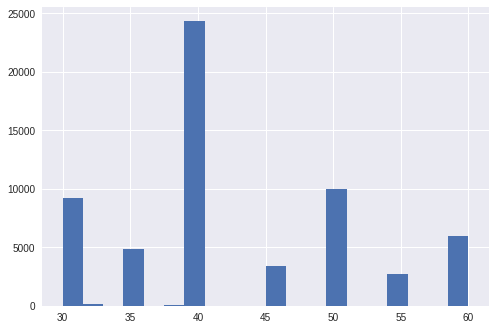

In [10]:
fig, ax = plt.subplots()
plt.hist(df_lpm_values['respchartvalue'],bins=20)

every_nth = 1
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.show()

In [11]:
df_diagnosis = run_query('''
SELECT * 
  FROM `physionet-data.eicu_crd.diagnosis`
WHERE patientunitstayid IN 
(
SELECT DISTINCT patientunitstayid FROM `physionet-data.eicu_crd.respiratorycharting`
WHERE respchartvaluelabel='LPM O2' AND REGEXP_CONTAINS(respchartvalue,'^[0-9]*$')
AND CAST(respchartvalue as numeric) >= 30
AND CAST(respchartvalue as numeric) <= 60
)
''')
df_diagnosis.head(10)

/usr/local/lib/python3.6/dist-packages/pandas_gbq/gbq.py:810: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  "verbosity", FutureWarning, stacklevel=1)


,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,8476692,449971,False,78,neurologic|misc|headache,R51,Major
1,45409785,3236765,False,2341,neurologic|misc|headache,R51,Major
2,45034356,3236765,False,7342,neurologic|misc|headache,R51,Major
3,45314059,3236765,False,122,neurologic|misc|headache,R51,Major
4,45013279,3236765,False,19216,neurologic|misc|headache,R51,Major
5,45264186,3236765,False,1321,neurologic|misc|headache,R51,Major
6,45102539,3236765,False,7907,neurologic|misc|headache,R51,Major
7,45067931,3236765,False,1316,neurologic|misc|headache,R51,Major
8,45068336,3236765,False,606,neurologic|misc|headache,R51,Major
9,45235169,3236765,False,955,neurologic|misc|headache,R51,Major


In [12]:
df_diagnosis['diagnosisstring'].value_counts()

pulmonary|respiratory failure|acute respiratory failure                                                 10330
renal|disorder of kidney|acute renal failure                                                             5268
pulmonary|respiratory failure|hypoxemia                                                                  3335
pulmonary|pulmonary infections|pneumonia                                                                 3244
cardiovascular|ventricular disorders|congestive heart failure                                            2512
cardiovascular|shock / hypotension|septic shock                                                          2415
cardiovascular|shock / hypotension|sepsis                                                                2228
cardiovascular|shock / hypotension|hypotension                                                           2157
hematology|bleeding and red blood cell disorders|anemia                                                  2120
gastrointe

## Begin table 1




In [0]:
data = df_high_flow.drop_duplicates(subset = ['unique_patients'])

In [89]:
data.head()

,age,gender,ethnicity,hospitalID,wardID,apacheAdmissionDx,admissionHeight,admissionWeight,hospitalDischargeYear,hospitalDischargeStatus,hospitalAdmitSource,patientunitstayid,unique_patients,respchartvalue,respChartOffset,respChartEntryOffset,respchartvaluelabel
0,68,Female,Caucasian,63,95,"CHF, congestive heart failure",160.0,126.2,2015,Alive,Emergency Department,173458,002-10086,30,405,405,LPM O2
5,59,Male,Caucasian,73,92,"CABG, minimally invasive; mid-CABG",175.3,116.7,2015,Alive,Operating Room,163413,002-10328,40,498,498,LPM O2
6,63,Female,Caucasian,73,92,CABG with aortic valve replacement,149.9,60.2,2015,Alive,Operating Room,155956,002-10444,40,1267,1267,LPM O2
18,45,Male,Caucasian,73,102,"Hemorrhage/hematoma, intracranial",177.8,136.1,2015,Alive,Emergency Department,188763,002-10665,30,2232,2232,LPM O2
29,31,Male,Caucasian,73,97,"Sepsis, pulmonary",190.5,114.8,2015,Alive,Floor,211974,002-10708,60,2514,2514,LPM O2


In [0]:
columns = ['age','gender','ethnicity','admissionWeight','admissionHeight']

In [0]:
categorical = ['gender','ethnicity']

In [0]:
groupby = ''
nonnormal = ['']

In [0]:
mytable = TableOne(data, columns, categorical, groupby, nonnormal)

In [94]:
mytable

isnull         overall
variable        level                                  
n                                                  3594
age                                   0   65.28 (15.40)
gender          Female                0    1571 (43.71)
                Male                       2022 (56.26)
                Unknown                        1 (0.03)
ethnicity                             0        9 (0.25)
                African American              212 (5.9)
                Asian                         21 (0.58)
                Caucasian                  3100 (86.25)
                Hispanic                     101 (2.81)
                Native American               23 (0.64)
                Other/Unknown                128 (3.56)
admissionWeight                     117   86.83 (30.97)
admissionHeight                      25  169.06 (11.47)
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: age, admissionHeight.
[2] Warning, Tukey test indicates far outliers in: admissionWeight, admissionHeight.
[3] Warning, test for normality reports non-normal distributions for: age, admissionWeight, admissionHeight.